# Prueba 2: Modificación de parámetros en efectos de sonido

## Inicialización FPGA

In [1]:
# Librería PYNQ
from pynq import Overlay, allocate
# Estructuras de datos y gráficos
import numpy as np
import matplotlib.pyplot as plt
# Librería MIDI
from mido import Message, MidiFile, MidiTrack, second2tick
# Librería lectura y creación de archivos de audio
from scipy.io import wavfile

In [2]:
# Controladores bloques de procesamiento
%run FFT_DMA_Driver.ipynb
%run Audio_DMA_Driver.ipynb
# Cargar Overlay FFT 
ol = Overlay('/home/xilinx/pynq/overlays/fft/disenofinal.bit')
# Inicializar DMAs, para enviar y recibir datos y configuración
fft = ol.fft_block
audio = ol.audio_block

## Carga de archivo de audio

In [3]:
# Cargar archivo de audio
SAMPLE_RATE, audio_data = wavfile.read("archivo1.wav")
print("Sample Rate: " + str(SAMPLE_RATE))

# Convertir a mono si es necesario
if len(audio_data.shape) > 1:
    audio_data = np.mean(audio_data, axis=1)

# Asegurarse de que el audio esté en formato int32
audio_data = (audio_data * np.iinfo(np.int32).max).astype(np.int32)

Sample Rate: 44100


/usr/lib/python3/dist-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


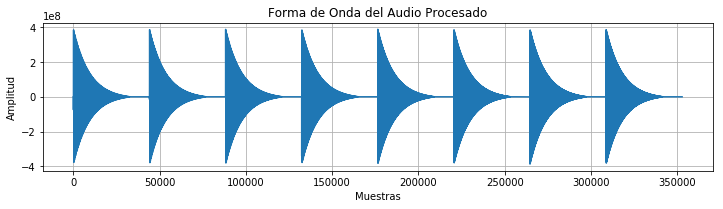

In [4]:
# Gráfica forma de onda
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(audio_data)
plt.title("Forma de Onda del Audio Procesado")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid(True)
plt.show()

## Configuración  e inicialización

In [4]:
# Inicialización parámetros y funciones
BLOCK_SIZE = 1024
audio.configure(BLOCK_SIZE)

# Buffer de entrada para DMA
input_buffer_audio = allocate(shape=(BLOCK_SIZE,), dtype=np.int32)

# Función para recibir el Audio Procesado
def apply_effects(input_data):
    np.copyto(input_buffer_audio, input_data.astype(np.int32))
    return audio.apply_effects(input_buffer_audio)

## Configuración 1 (Dist 1)

In [27]:
audio.gain_set_gain(5)
audio.rect_set_enable(0)
audio.clip_set_threshold(0.7)

In [28]:
%%time
# Procesar el audio
audio_results = []

block = np.zeros(BLOCK_SIZE, dtype=np.int32)

# Dividir el audio en bloques y aplicar efectos
for start in range(0, len(audio_data), BLOCK_SIZE):
    end = start + BLOCK_SIZE
    if end > len(audio_data):    
        block[:len(audio_data) - start] = audio_data[start:]
    else:
        block = audio_data[start:end].astype(np.int32)
    
    # Aplicar efectos (por ejemplo, ganancia) a los datos
    res_audio = apply_effects(block)
    
    # Imprimir los pares block - res_audio
    #print(f"Pares block - res_audio para el bloque {start//BLOCK_SIZE}:")
    #for idx, (original, processed) in enumerate(zip(block[:20], res_audio[:20])):
    #    print(f"Índice: {idx}, Original: {original}, Procesado: {processed}")
    
    audio_results.append(np.copy(res_audio))

CPU times: user 223 ms, sys: 128 µs, total: 223 ms
Wall time: 223 ms


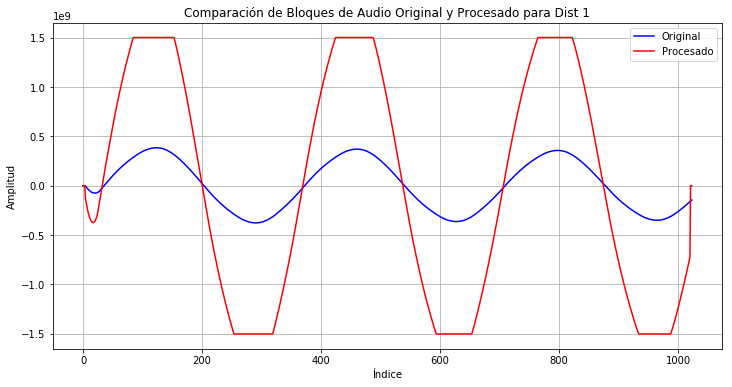

Archivo WAV creado y guardado como 'prueba2dist1.wav'.


In [29]:
# Graficar un bloque de audio
# Graficar un bloque de audio original y procesado
block_to_plot_original = audio_data[:BLOCK_SIZE]
block_to_plot_processed1 = audio_results[0]

plt.figure(figsize=(12, 6))
plt.plot(block_to_plot_original, label='Original', color='blue')
plt.plot(block_to_plot_processed1, label='Procesado', color='red')
plt.xlabel('Índice')
plt.ylabel('Amplitud')
plt.title('Comparación de Bloques de Audio Original y Procesado para Dist 1')
plt.legend()
plt.grid(True)
plt.show()

# Concatenar audio
processed_audio = np.concatenate([np.asarray(buffer) for buffer in audio_results])

# Guardar el archivo WAV
output_filename = 'prueba2dist1.wav'
wavfile.write(output_filename, SAMPLE_RATE, processed_audio)
print(f"Archivo WAV creado y guardado como '{output_filename}'.")

## Configuración 2 (Dist 2)

In [21]:
audio.gain_set_gain(8)
audio.rect_set_enable(1)
audio.clip_set_threshold(0.4)

In [22]:
%%time
# Procesar el audio
audio_results = []

block = np.zeros(BLOCK_SIZE, dtype=np.int32)

# Dividir el audio en bloques y aplicar efectos
for start in range(0, len(audio_data), BLOCK_SIZE):
    end = start + BLOCK_SIZE
    if end > len(audio_data):    
        block[:len(audio_data) - start] = audio_data[start:]
    else:
        block = audio_data[start:end].astype(np.int32)
    
    # Aplicar efectos (por ejemplo, ganancia) a los datos
    res_audio = apply_effects(block)
    
    # Imprimir los pares block - res_audio
    #print(f"Pares block - res_audio para el bloque {start//BLOCK_SIZE}:")
    #for idx, (original, processed) in enumerate(zip(block[:20], res_audio[:20])):
    #    print(f"Índice: {idx}, Original: {original}, Procesado: {processed}")
    
    audio_results.append(np.copy(res_audio))

CPU times: user 221 ms, sys: 47 µs, total: 222 ms
Wall time: 221 ms


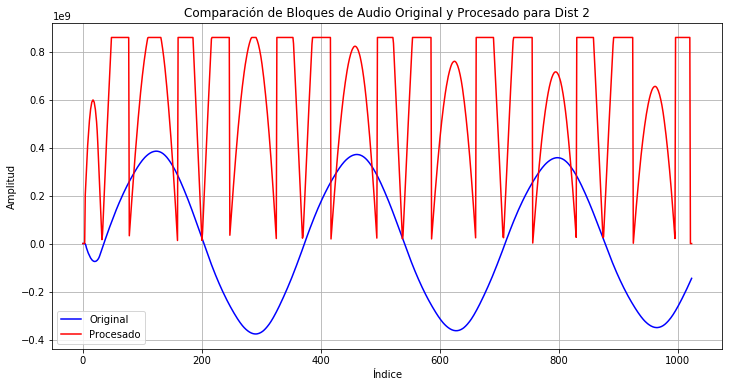

Archivo WAV creado y guardado como 'prueba2dist2.wav'.


In [23]:
# Graficar un bloque de audio
# Graficar un bloque de audio original y procesado
block_to_plot_original = audio_data[:BLOCK_SIZE]
block_to_plot_processed2 = audio_results[0]

plt.figure(figsize=(12, 6))
plt.plot(block_to_plot_original, label='Original', color='blue')
plt.plot(block_to_plot_processed2, label='Procesado', color='red')
plt.xlabel('Índice')
plt.ylabel('Amplitud')
plt.title('Comparación de Bloques de Audio Original y Procesado para Dist 2')
plt.legend()
plt.grid(True)
plt.show()

# Concatenar audio
processed_audio = np.concatenate([np.asarray(buffer) for buffer in audio_results])

# Guardar el archivo WAV
output_filename = 'prueba2dist2.wav'
wavfile.write(output_filename, SAMPLE_RATE, processed_audio)
print(f"Archivo WAV creado y guardado como '{output_filename}'.")